# Read / Format Data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import cv2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [2]:
!pip install xgboost
from xgboost import XGBClassifier


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
class Dataset:
    
    def __init__(self, dataset_image_path, 
               dataset_mask_path):
        self.dataset_image_path = dataset_image_path
        self.dataset_mask_path = dataset_mask_path
        
    def get_paths(self):
        self.images_dataset = list(pathlib.Path(self.dataset_image_path).glob("*.*"))
        self.masks_dataset = list(pathlib.Path(self.dataset_mask_path).glob("*.*"))
        
    def images_read(self, type_read):
        images = []
        if type_read == 'images':
            list_data = self.images_dataset
        else:
            list_data = self.masks_dataset
        for image in list_data:
            if type_read == 'images':
                img = cv2.imread(str(image))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = cv2.imread(str(image), 0)
            img = cv2.resize(img, (128, 128))
            img = img/255
            images.append(img)
        images = np.array(images)
        if type_read == 'images':
            self.images_data = images
        else:
            self.masks_data = images

In [5]:
lung_opacity_images_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset/Lung_Opacity/images'
lung_opacity_masks_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset/Lung_Opacity/masks'

lung_opacity_data = Dataset(lung_opacity_images_path, lung_opacity_masks_path)
lung_opacity_data.get_paths()

print(len(lung_opacity_data.images_dataset), len(lung_opacity_data.masks_dataset))

lung_opacity_data.images_read('images')
lung_opacity_data.images_read('masks')

6012 6012


In [7]:
covid_images_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset/COVID/images'
covid_masks_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset/COVID/masks'

covid_data = Dataset(covid_images_path, covid_masks_path)
covid_data.get_paths()

print(len(covid_data.images_dataset), len(covid_data.masks_dataset))

covid_data.images_read('images')
covid_data.images_read('masks')

3616 3616


In [8]:
viral_pneumonia_images_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset/Viral Pneumonia/images'
viral_pneumonia_masks_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset/Viral Pneumonia/masks'

viral_pneumonia_data = Dataset(viral_pneumonia_images_path, viral_pneumonia_masks_path)
viral_pneumonia_data.get_paths()

print(len(viral_pneumonia_data.images_dataset), len(viral_pneumonia_data.masks_dataset))

viral_pneumonia_data.images_read('images')
viral_pneumonia_data.images_read('masks')

1345 1345


In [9]:
normal_images_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset/Normal/images'
normal_masks_path = '/Users/eugfomitcheva/Desktop/COVID-19_Radiography_Dataset//Normal/masks'

normal_data = Dataset(normal_images_path, normal_masks_path)
normal_data.get_paths()

print(len(normal_data.images_dataset), len(normal_data.masks_dataset))

normal_data.images_read('images')
normal_data.images_read('masks')

10192 10192


In [10]:
def show_images_with_masks(figure_size, masks, images, alpha):
    plt.figure(figsize = figure_size)
    for i in range(64):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha = alpha, cmap = 'jet')
    plt.legend()

No handles with labels found to put in legend.


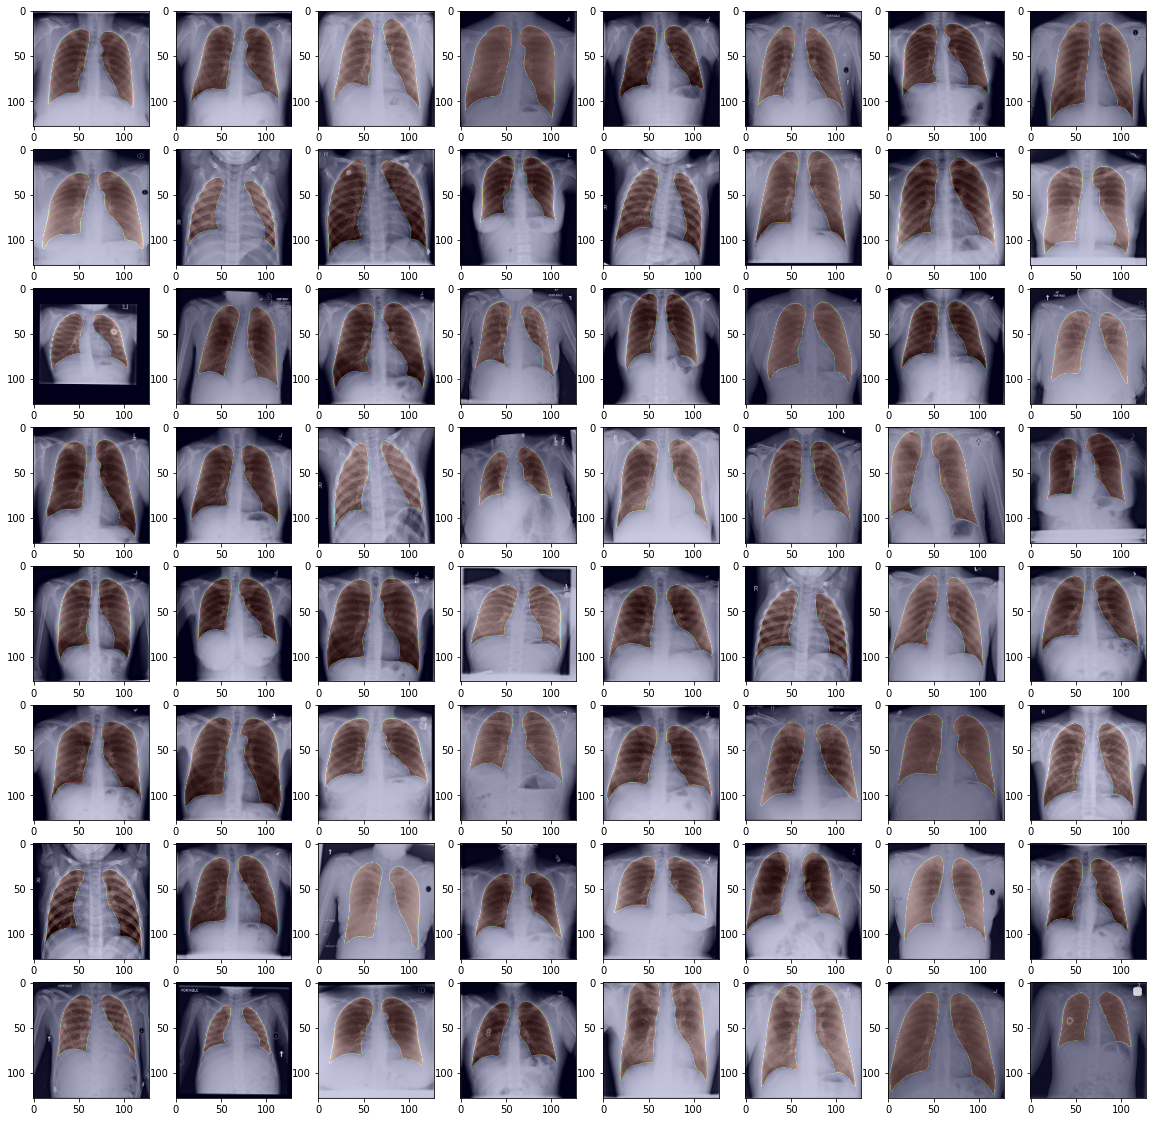

In [11]:
show_images_with_masks((20, 20), normal_data.masks_data, normal_data.images_data, 0.2)

# Create Functions to Calculate Metrics for Each Mask

In [10]:
def lung_frac(mask):
    total_pixels = len(mask.flatten())
    lung_pixels = np.count_nonzero(mask)
    lung_frac = lung_pixels / total_pixels
    return lung_frac

In [11]:
def left_right_ratio(mask):
    x_dim = mask.shape[1]
    split = int(x_dim / 2)
    left_image = mask[:, :split]
    left_lung_pixels = np.count_nonzero(left_image)
    right_image = mask[:, split:]
    right_lung_pixels = np.count_nonzero(right_image)
    left_right_ratio = left_lung_pixels / right_lung_pixels
    return left_right_ratio

In [12]:
def symmetricalness(mask):
    x_dim = mask.shape[1]
    split = int(x_dim / 2)
    left_image = mask[:, :split]
    right_image = mask[:, split:]
    
    flip_left = np.flip(left_image, 1)
    flip_left_flat = flip_left.flatten()
    right_flat = right_image.flatten()
    
    count = 0
    half_length = len(right_flat)
    for i in range(half_length):
        if right_flat[i] == flip_left_flat[i]:
            count += 1
            
    symmetricalness = count / len(mask.flatten())
    return symmetricalness

# 1. Logistic Regression Model to Predict Normal vs COVID

In [13]:
covid_masks = covid_data.masks_data
normal_masks = normal_data.masks_data

columns = ['Lung Fraction', 'Left/Right Lung Ratio', 'Symmetricalness', 'Diagnosis']
df = pd.DataFrame(columns=columns)

In [14]:
for i in range(len(normal_masks)):
    image_i = normal_masks[i]
    
    lung_frac_i = lung_frac(image_i)
    left_right_ratio_i = left_right_ratio(image_i)
    symmetricalness_i = symmetricalness(image_i)
    
    df = pd.concat([df, pd.DataFrame.from_records([{'Lung Fraction':lung_frac_i,
               'Left/Right Lung Ratio':left_right_ratio_i,
               'Symmetricalness':symmetricalness_i,
               'Diagnosis':0}])])

In [15]:
for i in range(len(covid_masks)):
    image_i = covid_masks[i]
    
    lung_frac_i = lung_frac(image_i)
    left_right_ratio_i = left_right_ratio(image_i)
    symmetricalness_i = symmetricalness(image_i)
    
    df = pd.concat([df, pd.DataFrame.from_records([{'Lung Fraction':lung_frac_i,
               'Left/Right Lung Ratio':left_right_ratio_i,
               'Symmetricalness':symmetricalness_i,
               'Diagnosis':1}])])

In [16]:
df = df.sample(frac=1).reset_index(drop=True)

train_frac = 0.8
num_rows = len(df)
split_idx = int(num_rows * train_frac)

train = df[:split_idx]
test = df[split_idx:]

X_train = train[['Lung Fraction', 'Left/Right Lung Ratio', 'Symmetricalness']]
X_test = test[['Lung Fraction', 'Left/Right Lung Ratio', 'Symmetricalness']]

y_train = train['Diagnosis']
y_train = y_train.astype('int')
y_test = test['Diagnosis']
y_test = y_test.astype('int')

In [17]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict_proba(X_test)[:, 1]

In [18]:
def AUC(y_pred, y_test, plot=None):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)

    if plot is not None:
        x = np.linspace(0, 1, 101)
        y = np.linspace(0, 1, 101)
        plt.plot(x, y, '--', color='r')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve, AUC={auc}')
        plt.grid()

    return auc

0.6035039420860004

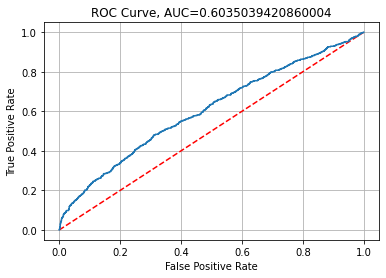

In [19]:
AUC(y_pred_log, y_test, True)

In [20]:
def prob_to_binary(y_pred_proba):
    num_covid = len(covid_masks)
    num_normal = len(normal_masks)
    covid_frac = num_covid / (num_covid + num_normal)
    covid_percentile = 100 - round(covid_frac*100, 0)
    threshold = np.percentile(y_pred_proba, covid_percentile)
    y_pred_binary = np.where(y_pred_proba > threshold, 1, 0)
    return y_pred_binary

In [21]:
y_pred_log_binary = prob_to_binary(y_pred_log)
logistic_acc = accuracy_score(y_test, y_pred_log_binary)
print(logistic_acc)

0.6683562635771181


# 2. Decision Tree Classifier to Predict Normal vs. COVID

0.6210968780398669

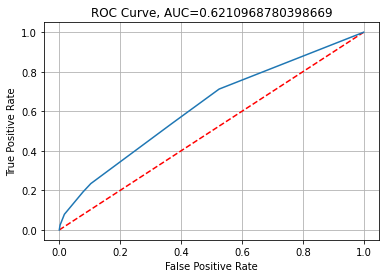

In [22]:
tree_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict_proba(X_test)[:, 1]
AUC(y_pred_tree, y_test, True)

In [23]:
y_pred_tree_binary = prob_to_binary(y_pred_tree)
tree_acc = accuracy_score(y_test, y_pred_tree_binary)
print(tree_acc)

0.720492396813903


# 3. XGBoost Classifier to Predict Normal vs. COVID

0.6591180556675211

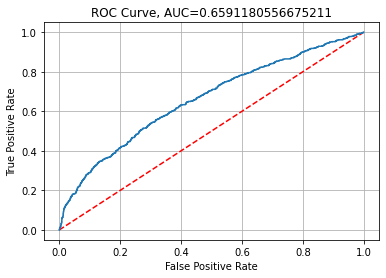

In [24]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
AUC(y_pred_xgb, y_test, True)

In [25]:
y_pred_xgb_binary = prob_to_binary(y_pred_xgb)
xgb_acc = accuracy_score(y_test, y_pred_xgb_binary)
print(xgb_acc)

0.6973207820419985


# 4. Naive Bayes Classifier to Predict Normal vs. COVID

0.6516581214495698

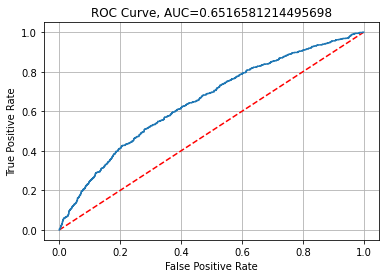

In [26]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict_proba(X_test)[:, 1]
AUC(y_pred_gnb, y_test, True)

In [27]:
y_pred_gnb_binary = prob_to_binary(y_pred_gnb)
gnb_acc = accuracy_score(y_test, y_pred_gnb_binary)
print(gnb_acc)

0.6958725561187545


# 5. KNN to Predict Normal vs. COVID

0.5780698289344275

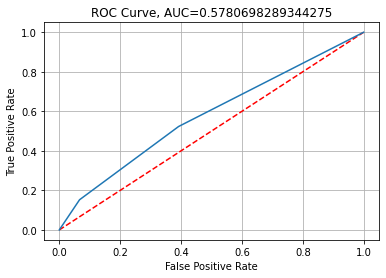

In [28]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict_proba(X_test)[:, 1]
AUC(y_pred_knn, y_test, True)

In [29]:
y_pred_knn_binary = prob_to_binary(y_pred_knn)
knn_acc = accuracy_score(y_test, y_pred_knn_binary)
print(knn_acc)

0.7259232440260681


# 6. SVM to Predict Normal vs. COVID

0.6554396487324595

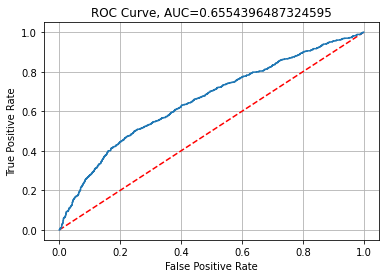

In [30]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)
y_pred_svm = clf.predict_proba(X_test)[:, 1]
AUC(y_pred_svm, y_test, True)

In [31]:
y_pred_svm_binary = prob_to_binary(y_pred_svm)
svm_acc = accuracy_score(y_test, y_pred_svm_binary)
print(svm_acc)

0.7067342505430847


# 7. Random Forest to Predict Normal vs. COVID

0.6688852656810108

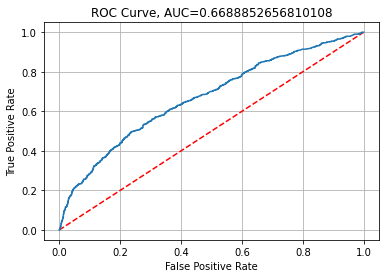

In [32]:
rf = RandomForestClassifier(max_depth=5)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
AUC(y_pred_rf, y_test, True)

In [33]:
y_pred_rf_binary = prob_to_binary(y_pred_rf)
rf_acc = accuracy_score(y_test, y_pred_rf_binary)
print(rf_acc)

0.7038377986965967
